# CostGrow PCRaster Inline

Port of `misc/example_pcraster.ipynb` with inlined CostGrow source logic for the PCRaster terrain-penalty path only.

Scope:
- Inline all required functions.
- Omit baseline, validation, and metrics.
- Show only a simple input/output plot at the end.

In [1]:
import logging
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rioxarray
import scipy.ndimage
import xarray as xr
from rasterio.enums import Resampling
from skimage.measure import label

import pcraster as pcr

print(f"python: {sys.version.split()[0]}")
print(f"numpy: {np.__version__}")
print(f"xarray: {xr.__version__}")
print(f"rioxarray: {rioxarray.__version__}")

python: 3.12.12
numpy: 2.4.2
xarray: 2025.11.0
rioxarray: 0.21.0


In [2]:
# Input paths and run controls.
REPO_DIR = Path.cwd().resolve()
if not (REPO_DIR / "tests").exists() and (REPO_DIR.parent / "tests").exists():
    REPO_DIR = REPO_DIR.parent

DATA_DIR = REPO_DIR / "tests" / "data" / "bryantTechnicalNoteResolution2024"
INPUT_DEM_FINE_FP = DATA_DIR / "dem_04m.tif"
INPUT_WSE_COARSE_FP = DATA_DIR / "wse_32m.tif"

# Pruned controls kept from source behavior.
DP_COARSE_PIXEL_MAX = 10
DECAY_FRAC = 0.001
DISTANCE_FILL_METHOD = "distance_transform_cdt"
DISTANCE_FILL_KWARGS = {"metric": "chessboard"}

print(f"REPO_DIR: {REPO_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"DEM exists: {INPUT_DEM_FINE_FP.exists()}")
print(f"Coarse WSE exists: {INPUT_WSE_COARSE_FP.exists()}")

REPO_DIR: /workspace
DATA_DIR: /workspace/tests/data/bryantTechnicalNoteResolution2024
DEM exists: True
Coarse WSE exists: True


In [3]:
# Plot helpers for lightweight input/output visualization.
DISPLAY_SHAPE = (450, 900)


def nn_resample_2d(arr: np.ndarray, target_shape=DISPLAY_SHAPE) -> np.ndarray:
    """Nearest-neighbor resize for fast notebook plotting."""
    assert arr.ndim == 2
    if arr.shape == target_shape:
        return arr
    yi = np.clip(np.round(np.linspace(0, arr.shape[0] - 1, target_shape[0])).astype(int), 0, arr.shape[0] - 1)
    xi = np.clip(np.round(np.linspace(0, arr.shape[1] - 1, target_shape[1])).astype(int), 0, arr.shape[1] - 1)
    return arr[np.ix_(yi, xi)]


def plot_raster(ax, da: xr.DataArray, title: str, cmap="viridis", vmin=None, vmax=None, target_shape=DISPLAY_SHAPE):
    """Plot a georeferenced raster with a compact metadata footer."""
    arr_disp = nn_resample_2d(da.data.astype(float), target_shape=target_shape)
    bounds = da.rio.bounds()
    im = ax.imshow(
        arr_disp,
        extent=(bounds[0], bounds[2], bounds[1], bounds[3]),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
        origin="upper",
        aspect="equal",
    )
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    raw_res = da.rio.resolution()
    ax.text(
        0.02,
        0.02,
        f"raw shape: {da.shape}\nraw res: ({raw_res[0]:.6f}, {raw_res[1]:.6f})",
        transform=ax.transAxes,
        fontsize=8,
        ha="left",
        va="bottom",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
    )
    return im

In [4]:
# Inline helpers copied from source behavior and simplified to this notebook scope.

def load_da(fp: Path, nodata=-9999.0) -> xr.DataArray:
    """Load a single-band GeoTIFF to float64 with nodata mapped to NaN."""
    da = rioxarray.open_rasterio(fp, masked=False).squeeze().compute().astype("float64").rio.write_nodata(nodata)
    return da.where(da != nodata, np.nan)


def dataarray_from_masked(masked_array: ma.MaskedArray, target_dataarray: xr.DataArray) -> xr.DataArray:
    """Build a DataArray from a masked array using target metadata and NaN nodata."""
    assert isinstance(masked_array, ma.MaskedArray), type(masked_array)
    assert isinstance(target_dataarray, xr.DataArray), type(target_dataarray)
    filled_array = ma.filled(masked_array, fill_value=np.nan)
    return xr.DataArray(
        filled_array,
        dims=target_dataarray.dims,
        coords=target_dataarray.coords,
        attrs=target_dataarray.attrs.copy(),
        name=target_dataarray.name,
    ).rio.write_crs(target_dataarray.rio.crs).rio.write_nodata(target_dataarray.rio.nodata)


def resample_match_xr(da: xr.DataArray, target_da: xr.DataArray, resampling=Resampling.bilinear) -> xr.DataArray:
    """Resample `da` onto `target_da` grid, preserving NaN nodata handling."""
    assert da.rio.crs == target_da.rio.crs
    nodata = da.rio.nodata
    da1 = da.fillna(nodata) if da.isnull().any() else da
    out = da1.rio.reproject_match(target_da, nodata=nodata, resampling=resampling).rio.write_nodata(nodata)
    return out.where(out != nodata, np.nan)


def _distance_fill(mar: ma.MaskedArray, method="distance_transform_cdt", **kwargs) -> np.ndarray:
    """Fill masked cells with nearest unmasked values using scipy distance transforms."""
    assert isinstance(mar, ma.MaskedArray), type(mar)
    assert mar.mask.any(), "array has no mask"
    assert not mar.mask.all(), "array is fully masked"
    f = getattr(scipy.ndimage, method)
    indices_ar = f(mar.mask.astype(int), return_indices=True, return_distances=False, **kwargs)
    filled_ar = mar.data.copy()
    filled_ar[mar.mask] = mar.data[tuple(indices_ar[:, mar.mask])]
    return filled_ar


def _distance_fill_cost_pcraster(wse_xr: xr.DataArray, cost_xr: xr.DataArray) -> xr.DataArray:
    """Fill masked WSE cells with PCRaster spreadzone over a terrain cost surface."""
    assert wse_xr.shape == cost_xr.shape
    assert np.all(np.isnan(cost_xr.data) | (cost_xr.data >= 0.0))

    nodata = wse_xr.rio.nodata
    wet_bar = wse_xr.notnull().data
    if not wet_bar.any():
        raise AssertionError("wse_xr has no wet/source cells")
    if wet_bar.all():
        return wse_xr.copy()

    rows, cols = wse_xr.shape
    west, _, _, north = wse_xr.rio.bounds()
    res_x, res_y = wse_xr.rio.resolution()
    cell_size = float(np.abs([res_x, res_y]).mean())
    pcr.setclone(int(rows), int(cols), cell_size, float(west), float(north))

    source_id_ar = np.zeros(wse_xr.shape, dtype=np.int32)
    source_idx_ar = np.flatnonzero(wet_bar.ravel())
    source_id_ar.ravel()[source_idx_ar] = np.arange(1, source_idx_ar.size + 1, dtype=np.int32)

    source_value_ar = wse_xr.data.ravel()[source_idx_ar].astype(np.float64)
    lookup_ar = np.full(source_idx_ar.size + 1, np.nan, dtype=np.float64)
    lookup_ar[1:] = source_value_ar

    cost_mv = -9999.0
    cost_ar = cost_xr.data.astype(np.float32, copy=True)
    invalid_cost_bar = np.logical_or(~np.isfinite(cost_ar), cost_ar < 0.0)
    cost_ar[invalid_cost_bar] = cost_mv

    points_map = pcr.numpy2pcr(pcr.Nominal, source_id_ar, -9999)
    friction_map = pcr.numpy2pcr(pcr.Scalar, cost_ar, cost_mv)
    zone_map = pcr.spreadzone(points_map, 0, friction_map)
    zone_ar = pcr.pcr2numpy(zone_map, 0).astype(np.int64, copy=False)

    max_zone = int(np.max(zone_ar))
    if max_zone > source_idx_ar.size:
        raise AssertionError(f"spreadzone returned source id {max_zone} > {source_idx_ar.size}")

    filled_ar = lookup_ar[zone_ar]
    filled_ar[invalid_cost_bar] = np.nan

    return xr.DataArray(
        filled_ar,
        coords=wse_xr.coords,
        dims=wse_xr.dims,
        attrs=wse_xr.attrs.copy(),
        name=wse_xr.name,
    ).rio.write_nodata(nodata).rio.write_crs(wse_xr.rio.crs)


def _distance_fill_cost_terrain(
    wse_fine_xr: xr.DataArray,
    dem_fine_xr: xr.DataArray,
    wse_coarse_xr: xr.DataArray,
    distance_fill_method="distance_transform_cdt",
    distance_fill_kwargs=None,
) -> xr.DataArray:
    """Terrain-penalty fill path from CostGrow using PCRaster spreadzone allocation."""
    if distance_fill_kwargs is None:
        distance_fill_kwargs = {}

    wse_coarse_filled_ar = _distance_fill(wse_coarse_xr.to_masked_array(), method=distance_fill_method, **distance_fill_kwargs)
    wse_coarse_filled_xr = dataarray_from_masked(ma.MaskedArray(wse_coarse_filled_ar), wse_coarse_xr)
    wse_filled_xr1 = resample_match_xr(wse_coarse_filled_xr, dem_fine_xr, resampling=Resampling.bilinear)

    delta_xr = wse_filled_xr1 - dem_fine_xr
    cost_xr = xr.where(delta_xr > 0, 1.0, 1.0 + np.abs(delta_xr))
    cost_xr = cost_xr.where(dem_fine_xr.notnull(), np.nan).rio.write_crs(dem_fine_xr.rio.crs)

    return _distance_fill_cost_pcraster(wse_fine_xr, cost_xr)


def _01_resamp(dem_fine_xr: xr.DataArray, wse_coarse_xr: xr.DataArray) -> xr.DataArray:
    """Phase 01: bilinear-resample coarse WSE to fine DEM grid."""
    return resample_match_xr(wse_coarse_xr, dem_fine_xr, resampling=Resampling.bilinear)


def _02_wet_partials(wse_fine_xr1: xr.DataArray, dem_fine_xr: xr.DataArray) -> xr.DataArray:
    """Phase 02: remove wet cells that are at or below the DEM."""
    dem_mar = dem_fine_xr.to_masked_array()
    wse_mar = wse_fine_xr1.to_masked_array()
    wse_mar2 = ma.MaskedArray(
        wse_mar.data.astype("float64"),
        mask=np.logical_or(np.logical_or(dem_mar.mask, wse_mar.mask), wse_mar <= dem_mar),
    )
    if wse_mar2.mask.all():
        raise AssertionError("02_wetPartials fully masked the input wet cells")
    return dataarray_from_masked(wse_mar2, wse_fine_xr1)


def _03_dry_partials(
    wse_fine_xr2: xr.DataArray,
    dem_fine_xr: xr.DataArray,
    wse_coarse_xr: xr.DataArray,
    downscale: int,
    pixel_size_m: float,
    dp_coarse_pixel_max=10,
    decay_frac=0.001,
    distance_fill_method="distance_transform_cdt",
    distance_fill_kwargs=None,
) -> xr.DataArray:
    """Phase 03: terrain-penalty growth + linear distance decay + DEM consistency."""
    assert downscale >= 1
    assert pixel_size_m > 0.0
    if distance_fill_kwargs is None:
        distance_fill_kwargs = {}

    f = getattr(scipy.ndimage, distance_fill_method)
    distance_ar = f(
        wse_fine_xr2.isnull().data.astype(int),
        return_indices=False,
        return_distances=True,
        **distance_fill_kwargs,
    ) * pixel_size_m

    if dp_coarse_pixel_max is None:
        grow_thresh_bar = np.full(distance_ar.shape, True)
    else:
        distance_coarse_pixel_ar = distance_ar / pixel_size_m / downscale
        grow_thresh_bar = distance_coarse_pixel_ar < dp_coarse_pixel_max

    wse_filled_xr = _distance_fill_cost_terrain(
        wse_fine_xr2,
        dem_fine_xr,
        wse_coarse_xr,
        distance_fill_method=distance_fill_method,
        distance_fill_kwargs=distance_fill_kwargs,
    )
    wse_filled_ar = wse_filled_xr.data

    decay_zone_bar = wse_fine_xr2.isnull().data
    decay_ar = np.where(decay_zone_bar, distance_ar * decay_frac, 0.0)
    wse_filled_decayed_ar = wse_filled_ar - decay_ar

    wse_fine_xr3 = wse_fine_xr2.fillna(
        np.where(
            np.logical_and(grow_thresh_bar, wse_filled_decayed_ar > dem_fine_xr.data),
            wse_filled_decayed_ar,
            np.nan,
        )
    ).where(dem_fine_xr.notnull(), np.nan)

    return wse_fine_xr3


def filter_isolated(source_bar: np.ndarray, anchor_bar: np.ndarray) -> np.ndarray:
    """Keep only connected wet regions that intersect anchor wet cells."""
    assert isinstance(source_bar, np.ndarray), type(source_bar)
    assert isinstance(anchor_bar, np.ndarray), type(anchor_bar)
    labels = label(source_bar.astype(int), connectivity=1)
    connected_labels = np.unique(labels[anchor_bar])
    connected_bar = np.isin(labels, connected_labels)
    return connected_bar


def downscale_costgrow_pcraster_inline(
    dem_fine_xr: xr.DataArray,
    wse_coarse_xr: xr.DataArray,
    dp_coarse_pixel_max=10,
    decay_frac=0.001,
    distance_fill_method="distance_transform_cdt",
    distance_fill_kwargs=None,
):
    """Inline CostGrow runner for terrain-penalty growth with PCRaster backend."""
    assert isinstance(dem_fine_xr, xr.DataArray), type(dem_fine_xr)
    assert isinstance(wse_coarse_xr, xr.DataArray), type(wse_coarse_xr)
    assert dem_fine_xr.rio.crs == wse_coarse_xr.rio.crs

    dem_bounds = np.array(dem_fine_xr.rio.bounds())
    wse_bounds = np.array(wse_coarse_xr.rio.bounds())
    if not np.allclose(dem_bounds, wse_bounds, atol=1e-6):
        raise AssertionError(f"Bounds mismatch: DEM={dem_bounds}, WSE={wse_bounds}")

    coarse_shape = wse_coarse_xr.shape
    shape_rat_t = tuple(dem_fine_xr.shape[i] / coarse_shape[i] for i in range(2))
    if not np.allclose(shape_rat_t[0], shape_rat_t[1], atol=1e-6):
        raise AssertionError(f"Shape ratios are not consistent: {shape_rat_t}")
    downscale = int(round(shape_rat_t[0]))
    if downscale < 1:
        raise AssertionError(f"Invalid downscale={downscale}")

    pixel_size_m = float(np.abs(dem_fine_xr.rio.resolution()).mean())

    # Phase 01: resample to target grid.
    wse_fine_xr1 = _01_resamp(dem_fine_xr, wse_coarse_xr)

    # Phase 02: retain only wet-above-ground partials.
    wse_fine_xr2 = _02_wet_partials(wse_fine_xr1, dem_fine_xr)

    # Phase 03: grow dry partials with terrain-penalty costs and linear decay.
    wse_fine_xr3 = _03_dry_partials(
        wse_fine_xr2,
        dem_fine_xr,
        wse_coarse_xr,
        downscale=downscale,
        pixel_size_m=pixel_size_m,
        dp_coarse_pixel_max=dp_coarse_pixel_max,
        decay_frac=decay_frac,
        distance_fill_method=distance_fill_method,
        distance_fill_kwargs=distance_fill_kwargs,
    )

    # Phase 04: remove isolated grown patches disconnected from wet anchors.
    connected_bar = filter_isolated(wse_fine_xr3.notnull().data, wse_fine_xr2.notnull().data)
    wse_fine_xr4 = wse_fine_xr3.where(connected_bar, np.nan).where(dem_fine_xr.notnull(), np.nan)

    meta_d = {
        "downscale": downscale,
        "dp_coarse_pixel_max": dp_coarse_pixel_max,
        "decay_frac": decay_frac,
        "distance_fill_method": distance_fill_method,
        "wet_anchors": int(wse_fine_xr2.notnull().sum().item()),
        "wet_final": int(wse_fine_xr4.notnull().sum().item()),
    }
    return wse_fine_xr4, meta_d

In [5]:
# Load source rasters and run the inline CostGrow pipeline.
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(name)s: %(message)s")
log = logging.getLogger("CostGrow_pcraster_inline")

for fp in [INPUT_DEM_FINE_FP, INPUT_WSE_COARSE_FP]:
    if not fp.exists():
        raise FileNotFoundError(fp)

dem_fine_xr = load_da(INPUT_DEM_FINE_FP)
wse_coarse_xr = load_da(INPUT_WSE_COARSE_FP)

run_start = time.perf_counter()
wse_downscaled_xr, meta_d = downscale_costgrow_pcraster_inline(
    dem_fine_xr,
    wse_coarse_xr,
    dp_coarse_pixel_max=DP_COARSE_PIXEL_MAX,
    decay_frac=DECAY_FRAC,
    distance_fill_method=DISTANCE_FILL_METHOD,
    distance_fill_kwargs=DISTANCE_FILL_KWARGS,
)
run_seconds = time.perf_counter() - run_start

log.info(f"Finished in {run_seconds:,.3f} sec")
print(meta_d)

2026-02-22 18:28:20,536 INFO CostGrow_pcraster_inline: Finished in 9.142 sec


{'downscale': 8, 'dp_coarse_pixel_max': 10, 'decay_frac': 0.001, 'distance_fill_method': 'distance_transform_cdt', 'wet_anchors': 425253, 'wet_final': 447906}


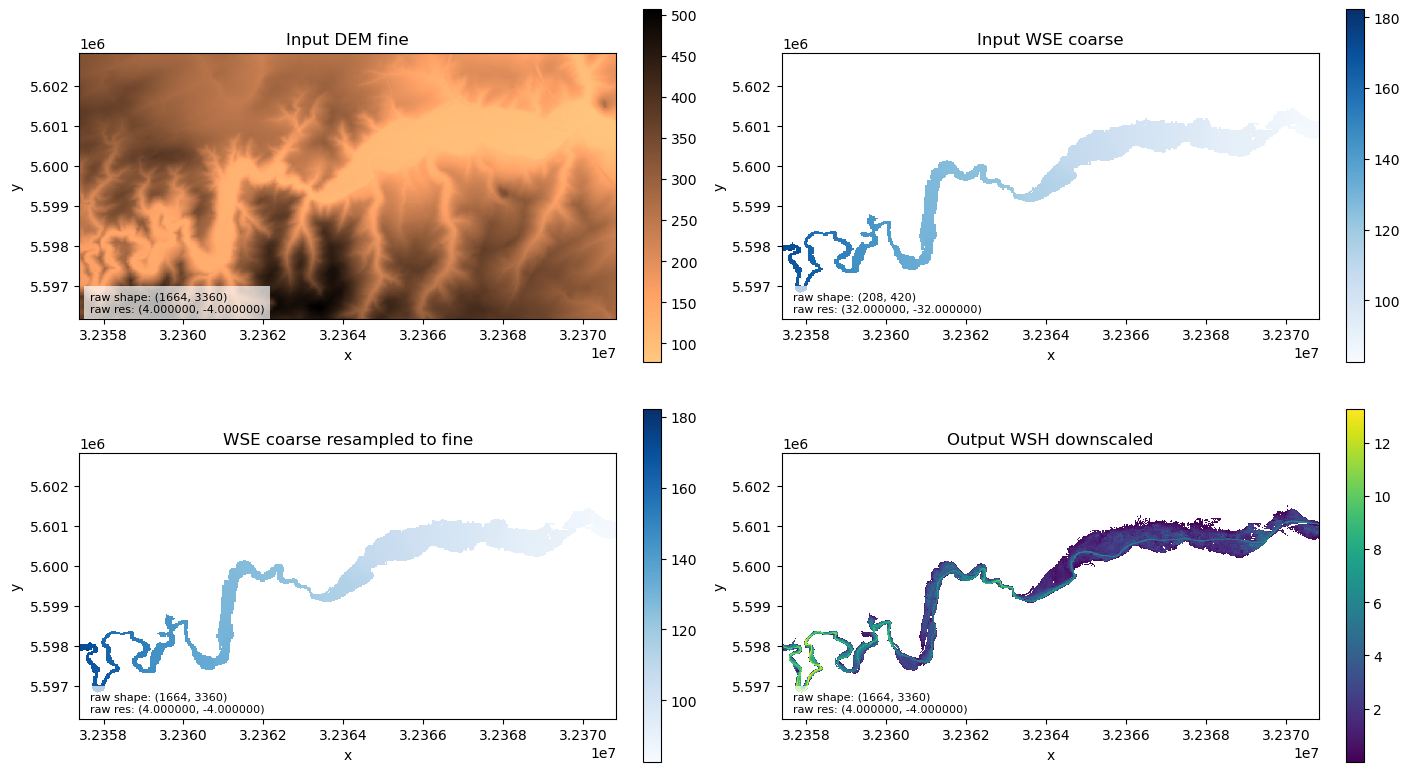

In [6]:
# Build a simple input/output panel.
wse_resampled_xr = resample_match_xr(wse_coarse_xr, dem_fine_xr, resampling=Resampling.bilinear)
wsh_downscaled_xr = xr.where(wse_downscaled_xr.notnull(), wse_downscaled_xr - dem_fine_xr, np.nan)

fig, axes = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)

im0 = plot_raster(axes[0, 0], dem_fine_xr, "Input DEM fine", cmap="copper_r")
fig.colorbar(im0, ax=axes[0, 0], shrink=0.9)

im1 = plot_raster(axes[0, 1], wse_coarse_xr, "Input WSE coarse", cmap="Blues")
fig.colorbar(im1, ax=axes[0, 1], shrink=0.9)

im2 = plot_raster(axes[1, 0], wse_resampled_xr, "WSE coarse resampled to fine", cmap="Blues")
fig.colorbar(im2, ax=axes[1, 0], shrink=0.9)

im3 = plot_raster(axes[1, 1], wsh_downscaled_xr, "Output WSH downscaled", cmap="viridis")
fig.colorbar(im3, ax=axes[1, 1], shrink=0.9)

plt.show()